# Word embeddings

El algoritmo de word embeddings busca obtener representaciones vectoriales de palabras a patrtir de optimizar una función de probabilidad condicional. Al igual que con los modelos de DSM, necesitamos definir una bolsa de palabras.

In [1]:
%matplotlib inline
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def vocab():
    dicc = defaultdict()
    dicc.default_factory = lambda: len(dicc)
    return dicc

def BoW(corpus,vocab):
    for w in corpus:
        yield[vocab[w_i] for w_i in w.split()]

También definiremos una función de ploteo para observar cómo funciona el algoritmo:

In [2]:
def plot_words(Z,ids):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label.decode('utf8'), xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

Ahora supongamos que tenemos las siguientes oraciones:

In [3]:
sentences = [
            'gato perro',
            'gato corre',
            'perro gato',
            'perro corre',
            'perro ladra'
            ]

Y obténgase la bolsa de palabras de estas oraciones.

In [4]:
V = vocab()
words = list(BoW(sentences,V))

En este caso, queremos definir una red neuronal con una capa oculta, aquí trataremos de optimizar sobre estos parámetros. Por tanto, crearemos dos matrices. La primera matriz es la matriz de entrada: ésta contendrá los k vectores correspondientes al vocabulario y tendrá una dimensión n. Por su parte, la matriz de salida corresponderá a la matriz de pesos de la capa oculta. Esta matriz es de nxk; sin embargo no es simplemente la transpuesta de la matriz de entrada, si no que iniciará aleatoriamente.

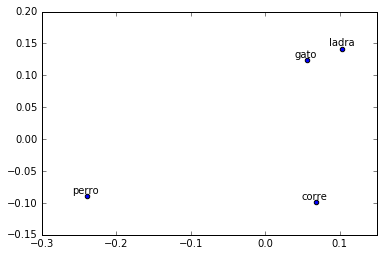

In [5]:
k = len(V)
n = 2

WI = (np.random.random((k,n)) - 0.5) / n
WO = (np.random.random((n,k)) - 0.5) / n

plot_words(WI, V.keys())

La suposición inicial del algoritmo de word embeddings es que cada una de las palabras tiene un vector de inicio asignado aleatoriamente a partir de las matrices definidas. Buscamos, entonces, minimizar la función de pérdida dada por L = -log P(w_O|w_I) donde P(w_O|w_I) es la función Softmax.

In [6]:
def softmax(w_O, w_I):
    return np.exp(-np.dot(WO.T[V[w_O]], WI[V[w_I]])) / sum( np.exp(-np.dot(WO.T[V[w]], WI[V[w_I]])) for w in V )

Podemos calcular la probabilidad de perro dado gato.

In [7]:
print softmax('perro', 'gato')

0.250860953171


Con la función Softmax definida, determinaremos el error como t - P(w_O|w_I) donde t=1 si w_O es la palabra objetivo y t=0 si no. También calcularemos el gradiente descendiente estocástico con base en este error y propagaremos el error. En este caso 'a' es el rango de aprendizaje.

In [8]:
def upgrade(target_word, w_I, a=1.0):
    for w_O in V:
        p_w = softmax(w_O, w_I)
        t = 1 if w_O == target_word else 0
        err = t - p_w
    
        #A partir de esto podemos aplicar el gradiente descendiente
        WO.T[V[w_O]] -= a*err*WI[V[w_I]] 

    #Aplicamos ahora la retropropagación de error
    WI[V[w_I]] -= a*WO.sum(1)

Esta función upgrade() nos ayudará a actualizar los parámetros de la red neuronal, en este caso las matrices, hasta llegar a un óptimo. Por ejemplo, si aplicamos la función a las palabras gato y perro. 

In [9]:
upgrade('perro', 'gato')

Podemos ver que la probabilidad aumento, ya que estoy suponiendo que aparecen ambras palabras en el mismo contexto.

In [10]:
for w in V:
    print w, softmax('perro', w)

gato 0.262037286609
perro 0.236421149579
corre 0.252609787317
ladra 0.257115824317


Por tanto, el espacio vectorial debió modificarse. Compárese con el obtenido anteriormente. Se verá que los vectores de perro y gato están un poco más cercanos.

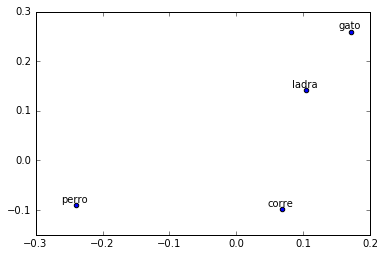

In [11]:
plot_words(WI, V.keys())

Y si hacemos otras iteraciones.

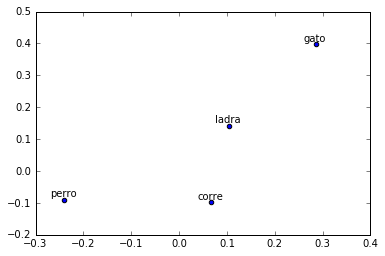

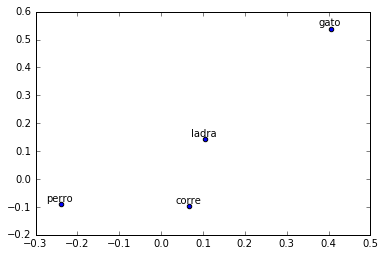

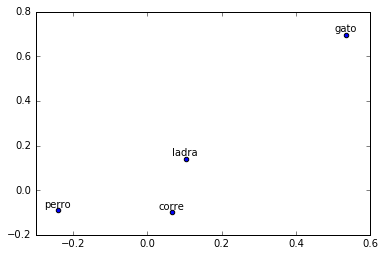

In [12]:
for i in range(0,3):
    upgrade('perro', 'gato')
    plot_words(WI, V.keys())    

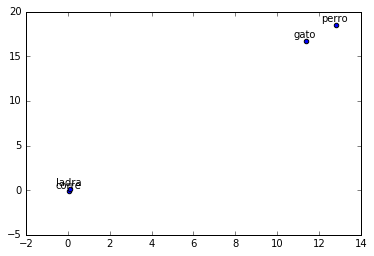

In [20]:
from itertools import combinations

for i in range(0,100):
    for s in sentences:
        x,y = s.split()
        upgrade(y, x, a=0.1)
plot_words(WI, V.keys())

Podemos notar, que el algoritmo genera un espacio en el que los sustantivos 'gato' y 'perro' son separables de las palabras correspondientes a los verbos.